批处理ESD表格，主要把时间戳转化为时间轴

In [1]:
import os
import pandas as pd

dirlist = os.listdir('../CollectedData/BINS/')
print(dirlist)
for i in dirlist:
    data = pd.read_csv('../CollectedData/BINS/'+i)
    time_df = data.iloc[:,0] # 获取时间戳的那一列
    bins_df = data.iloc[:,1:-1] # 获取bins的列
    data['max'] = bins_df.max(axis=1) # 找到bins中每一行的最大值，并且赋值给max列
    data['time'] = (time_df-time_df[0])/1000
    output = data[['time','max']]
    output.to_csv('../CollectedData/OutBINS/out_'+i, index=False)

['TEST_BINS1.csv', 'TEST_BINS12.csv', 'TEST_BINS2.csv', 'TEST_BINS3.csv', 'TEST_BINS4.csv', 'TEST_BINS5.csv', 'TEST_BINS6.csv', 'TEST_BINS7.csv', 'TEST_BINS9.csv']


超声波信号和音频信号相乘

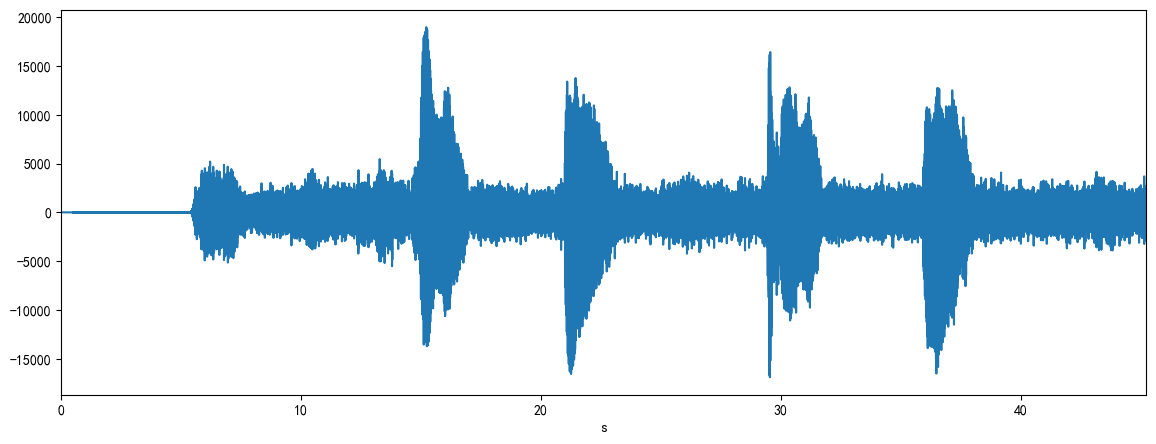

In [11]:
import utils.speechlib
from utils.soundBase import soundBase

sb = soundBase('../CollectedData/WAV/SingleWav1.wav') # 读取音频文件
data , fs = sb.audioread()
sb.soundplot(data)
